In [2]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
from datetime import datetime, time
import seaborn as sns

In [4]:
from data.subjects_to_keep import subjects_to_keep as users
from data.data_path import data_path

Prop excl: 0.0016832025734297123
(106939,)
bounds:  -28217170.708368037 32658410.158117477
Prop excl: 0.00620914727087405
180000.00000241792


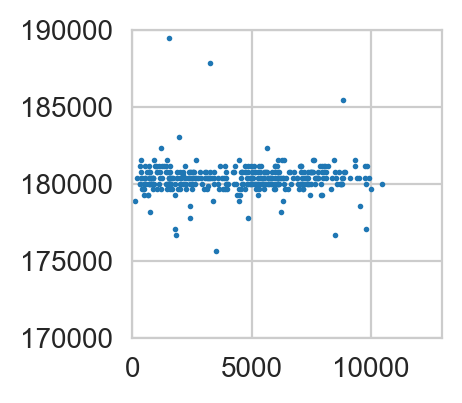

In [7]:
for u in users:  
    # u =  users[0] #"11KD" #"09AU"  "11KD"
    file = glob(f"{data_path}/dump_latest/{u}_activity*.csv")[0]
    #     print(f"Found the file `{file}`")
    
    df = pd.read_csv(file, index_col=0)
    df.dt = pd.to_datetime(df.dt, utc=False, format='ISO8601')
    df.dt = df.dt.dt.tz_convert('Europe/London')
    
    all_pos = df.step_midnight.values
    
    min_date = df.dt.min().date()
    days = np.asarray([(dt.date() - min_date).days for dt in df.dt])
    uniq_days = np.unique(days)
    all_timestep = (np.asarray([(dt - datetime.combine(dt, time.min, dt.tz)).total_seconds() for dt in df.dt]) / 86400)
    
    all_x = np.empty(shape=(0,))
    all_xdiff = np.empty(shape=(0,))
    all_ydiff = np.empty(shape=(0,))
    
    for day in uniq_days:
        
        is_day = days == day
        obs_timestep, obs_pos = all_timestep[is_day], all_pos[is_day]
        
        # Compute the diff
        xdiff = np.diff(obs_timestep)
        ydiff = np.diff(obs_pos) / xdiff
        x = obs_pos[:-1]  # Forward approximation
        
        all_x = np.concatenate([all_x, x])
        all_xdiff = np.concatenate([all_xdiff, xdiff])
        all_ydiff = np.concatenate([all_ydiff, ydiff])
    
    _mean = np.mean(all_xdiff)
    _std = np.std(all_xdiff)
    lw_bd = _mean - _std
    up_bd = _mean + _std
    to_exclude_because_x = (all_xdiff > up_bd) + (all_xdiff < lw_bd)
    print(f"Prop excl: {np.sum(to_exclude_because_x)/to_exclude_because_x.size}")
    
    _mean = np.mean(all_ydiff)
    _std = np.std(all_ydiff)
    lw_bd = _mean - _std
    up_bd = _mean + _std
    to_exclude_because_y = (all_ydiff > up_bd) + (all_ydiff < lw_bd)
    print(to_exclude_because_y.shape)
    print("bounds: ", lw_bd, up_bd)
    print(f"Prop excl: {np.sum(to_exclude_because_y)/to_exclude_because_y.size}")
    
    all_x = all_x[~(to_exclude_because_x+to_exclude_because_y)]
    all_xdiff = all_xdiff[~(to_exclude_because_x+to_exclude_because_y)]
    all_ydiff = all_ydiff[~(to_exclude_because_x+to_exclude_because_y)]
    
    #fig, ax = plt.subplots(figsize=(1.5, 1.5))
    #ax.scatter(all_x, all_ydiff, s=1, alpha=0.01)
    #ax.set_xscale("log")
    #ax.set_yscale("log")
    # plt.show()
    
    idx = np.random.choice(np.arange(all_x.size), size=1000, replace=False)
    # all_x, all_ydiff = all_x[idx], all_ydiff[idx]
    fig, ax = plt.subplots(figsize=(2, 2))
    ax.scatter(all_x[idx], all_ydiff[idx], s=1, alpha=1)
    ax.set_xlim(0, 13000)
    print(np.median(all_ydiff[idx]))
    ax.set_ylim(170000, 190000)
    
    #g = sns.jointplot(x=all_x[idx], y=all_ydiff[idx], kind="scatter") #, kind="hex", bins="log", gridsize=50)
    #g.ax_joint.set_yscale('log')
    break


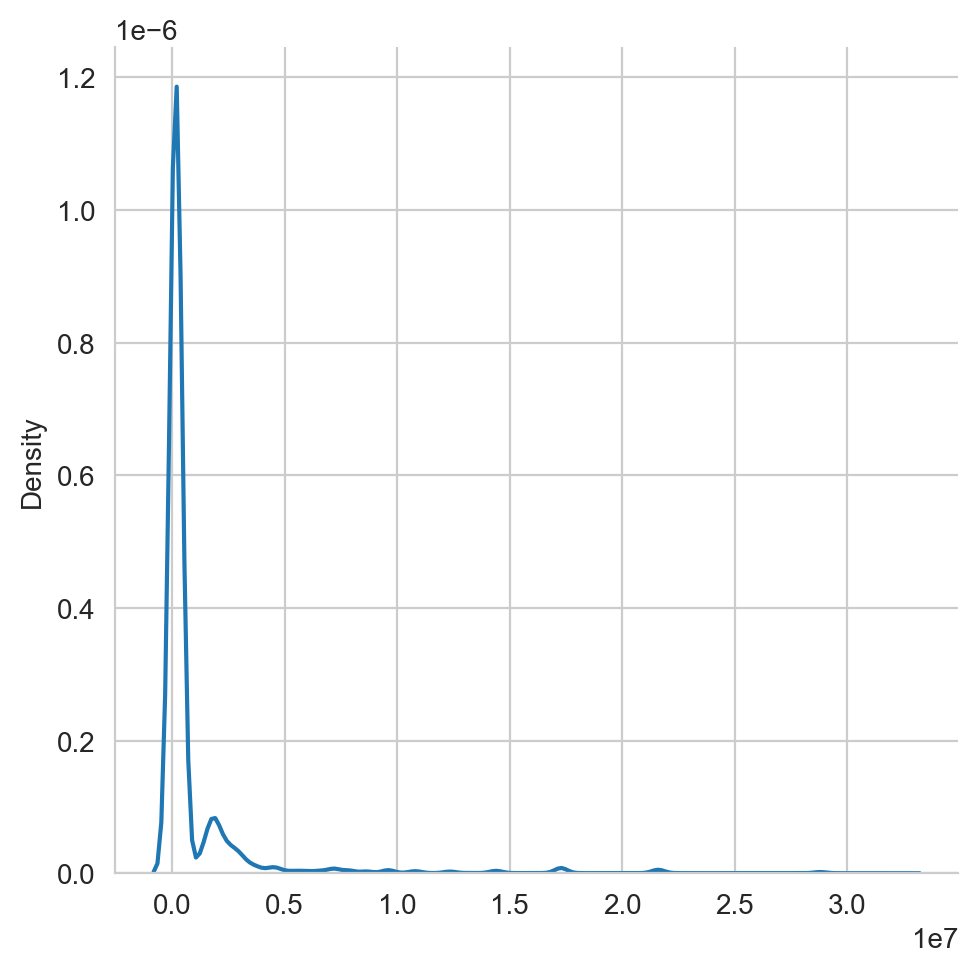

In [6]:
sns.displot(all_ydiff, kind="kde")

In [38]:
np.min(all_xdiff)*86400, np.max(all_xdiff)*86400, np.mean(all_xdiff)*86400, np.std(all_xdiff)*86400

(0.001999999992818857, 58813.927, 5.830543618324466, 300.43918940882384)

In [39]:
300/60

5.0

In [40]:
np.sum(all_xdiff>np.mean(all_xdiff)+3*np.std(all_xdiff))/all_xdiff.size

0.0007200366564115991

In [5]:
alpha_tpvv = np.zeros((n_timestep, n_position, n_velocity, n_velocity))

NameError: name 'n_timestep' is not defined

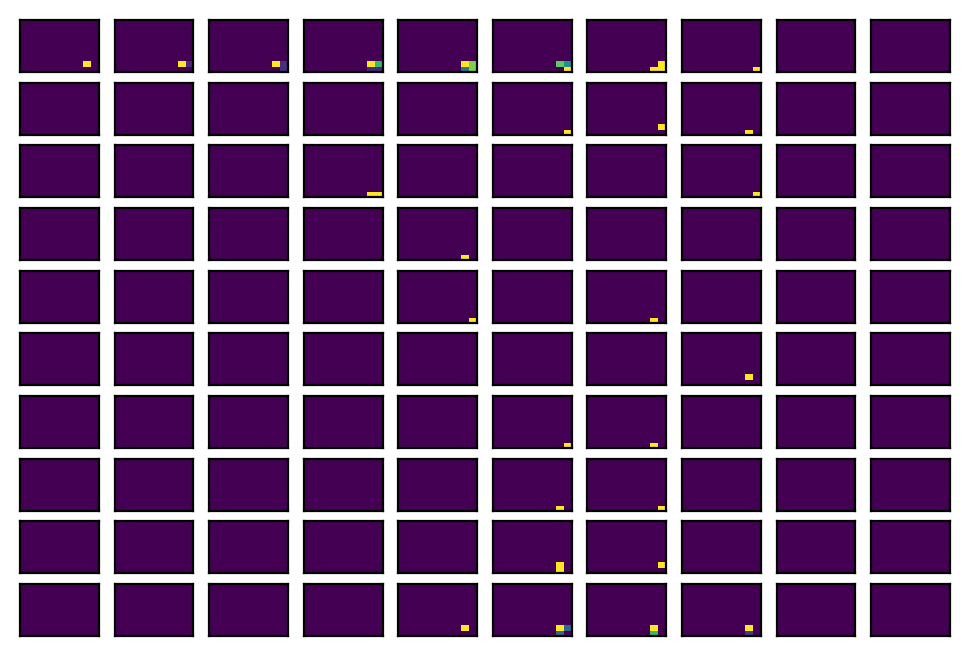

In [133]:
fig, axes = plt.subplots(
                nrows=n_position,
                ncols=n_timestep,
                figsize=(6, 4))
for t_idx in range(n_timestep):
    for p_idx in range(n_position):
        ax = axes[p_idx, t_idx]
        img = alpha_tpvv[t_idx, p_idx, :, :]
        ax.imshow(img, aspect="auto")
        ax.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])
plt.show()

In [9]:
position = np.linspace(0, 7000, 10)
velocity = np.linspace(-50000, 5000, 10)
timestep = np.linspace(0, 1, 10)
dp = position[1] - position[0]
dt = timestep[1] - timestep[0]
dv = velocity[1] - velocity[0]
n_timestep = timestep.size
n_position = position.size
n_velocity = velocity.size

Think about:
- removing the data points when there is no change in position
- adding a data point at the beginning of the day with position 0, and a data point at the end of the day with last observed position 
